In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
import scipy.sparse as sp
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import optuna
from optuna.trial import TrialState
from optuna.integration import XGBoostPruningCallback
import matplotlib.pyplot as plt
from sklearn.linear_model import ElasticNet


In [2]:
# import df.csv

df = pd.read_csv('df.csv')

C:\Users\felix.wente\AppData\Local\Temp\ipykernel_7580\3391109823.py:3: DtypeWarning: Columns (27,28,29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('df.csv')


In [3]:
# Assume your dataframe is df and your date column is 'date'

# Convert date to datetime if it's not already
df['Date'] = pd.to_datetime(df['Date'])

# Sort by date
df.sort_values('Date', inplace=True)

# Remove rows where the 'Injury' column has NA values
df = df.dropna(subset=['Injury'])

# Get unique dates
unique_dates = df['Date'].unique()

# Decide how many dates to include in each set
train_dates = int(len(unique_dates) * 0.8)

# Find the index of the last training date
last_train_idx = df[df['Date'] == unique_dates[train_dates]].index[-1]

# Now you can create your train and test sets
train = df.iloc[:last_train_idx + 1]
test = df.iloc[last_train_idx + 1:]



In [4]:
# Identify categorical columns excluding the date column
cat_cols = train.select_dtypes(include=['object']).columns.tolist()

# Initialize OneHotEncoder
ohe = OneHotEncoder(sparse=True, handle_unknown='ignore')

# Fit the OneHotEncoder on the training data and transform both train and test data
ohe.fit(train[cat_cols])
one_hot_encoded_train = ohe.transform(train[cat_cols])
one_hot_encoded_test = ohe.transform(test[cat_cols])

# Extract numeric data
numeric_data_train = train.drop(cat_cols + ['Date', 'Injury'], axis=1).values
numeric_data_test = test.drop(cat_cols + ['Date', 'Injury'], axis=1).values


# Combine sparse and dense data
final_data_train = sp.hstack((one_hot_encoded_train, numeric_data_train)).tocsr()
final_data_test = sp.hstack((one_hot_encoded_test, numeric_data_test)).tocsr()



# Set up for cross-validation
X = final_data_train
y = train["Injury"].values  # replace "Injury" with your target column name

X_test = final_data_test
y_test = test["Injury"].values

# Initialize a TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=5)



In [5]:
rows, cols = X.shape
print(f"Number of rows: {rows}")
print(f"Number of columns: {cols}")


Number of rows: 223854
Number of columns: 284


In [8]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_uniform('gamma', 0.0, 1.0),
        'objective': 'reg:squarederror',
        #'tree_method': 'gpu_hist',  # use GPU-based algorithm
        #'gpu_id': 1  # ID of the GPU to use
    }

    num_boost_round = trial.suggest_int('num_boost_round', 50, 500)
    early_stopping_rounds = 50  # Stop if performance hasn't improved for 50 rounds

    mse_scores = []
    for train_index, val_index in tscv.split(X):
        X_train_cv, X_val_cv = X[train_index], X[val_index]
        y_train_cv, y_val_cv = y[train_index], y[val_index]

        # Convert to DMatrix
        dtrain = xgb.DMatrix(X_train_cv, label=y_train_cv)
        dval = xgb.DMatrix(X_val_cv, label=y_val_cv)

        # Train the model
        model = xgb.train(
            params, 
            dtrain,
            num_boost_round=num_boost_round,
            evals=[(dval, 'eval')],
            early_stopping_rounds=early_stopping_rounds,
            verbose_eval=False
        )
        # Predict the validation set
        y_pred = model.predict(dval)

        mse = mean_squared_error(y_val_cv, y_pred)
        mse_scores.append(mse)

    return np.mean(mse_scores)

# Create a study that uses SQLite storage
study = optuna.create_study(direction='minimize', storage='sqlite:///example.db', load_if_exists=True, study_name='no-name-286bbea7-b86c-450d-af18-d85fcadd081f')  



[I 2023-06-27 10:15:14,704] Using an existing study with name 'no-name-286bbea7-b86c-450d-af18-d85fcadd081f' instead of creating a new one.


In [9]:

# Optimize the study
study.optimize(objective, n_trials=100, catch=(Exception,))

C:\Users\felix.wente\AppData\Local\Temp\ipykernel_7580\2821873922.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
C:\Users\felix.wente\AppData\Local\Temp\ipykernel_7580\2821873922.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
C:\Users\felix.wente\AppData\Local\Temp\ipykernel_7580\2821873922.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.

KeyboardInterrupt: 

In [10]:
# Extract the best parameters
best_params = study.best_params




early_stopping_rounds = 50 # Stop if performance hasn't improved for 50 rounds

# Prepare the DMatrix format for the entire training data and test data
dtrain_full = xgb.DMatrix(X, label=y)
dtest = xgb.DMatrix(X_test, label=y_test)  # Ensure X_test and y_test are prepared

# Train the model with the best parameters on the training data
final_model = xgb.train(
    best_params, 
    dtrain_full, 
    early_stopping_rounds=early_stopping_rounds,
    evals=[(dtrain_full, 'train')],
    verbose_eval=True 
    
)

# Make predictions on the test data
predictions_test = final_model.predict(dtest)

# Calculate mean squared error on the test data
mse_test = mean_squared_error(y_test, predictions_test)

print("Mean squared error on the test data: ", mse_test)




[10:15:54] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "num_boost_round" } are not used.

[0]	train-rmse:5.72877
[1]	train-rmse:3.64076
[2]	train-rmse:2.31379
[3]	train-rmse:1.47047
[4]	train-rmse:0.93454
[5]	train-rmse:0.59399
[6]	train-rmse:0.37755
[7]	train-rmse:0.24004
[8]	train-rmse:0.15268
[9]	train-rmse:0.09721
Mean squared error on the test data:  0.008485045295997683


In [11]:
best_params

{'colsample_bytree': 0.9165498070846373,
 'gamma': 0.770691118039721,
 'learning_rate': 0.36449164747442575,
 'max_depth': 8,
 'num_boost_round': 367,
 'subsample': 0.5948698632120203}

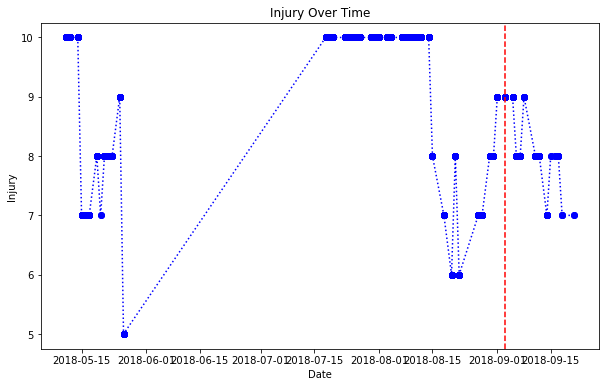

In [12]:
# Assuming 'df' is your DataFrame containing the 'Date' and 'Injury' columns
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['Injury'], marker='o', linestyle=':', color='blue')

# Calculating the cutoff date at 80% of the data
cutoff_percentage = 0.8
cutoff_index = int(len(df) * cutoff_percentage)
cutoff_date = df['Date'].iloc[cutoff_index]

# Adding the vertical red dotted line at the cutoff date
plt.axvline(x=cutoff_date, color='red', linestyle='--')

plt.title('Injury Over Time')
plt.xlabel('Date')
plt.ylabel('Injury')
plt.show()

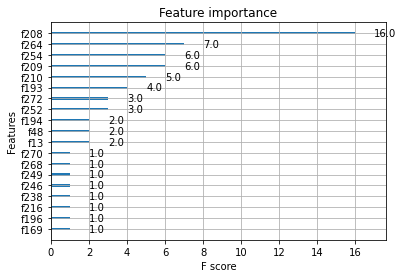

In [13]:


# Let's plot the feature importance
xgb.plot_importance(final_model)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()


In [ ]:
# Get one-hot encoded feature names
ohe_feature_names = ohe.get_feature_names_out(cat_cols)

# Get numeric feature names
numeric_feature_names = train.drop(cat_cols + ['Date'], axis=1).columns

# Combine both lists
all_feature_names = np.concatenate([ohe_feature_names, numeric_feature_names])

# Now you can find the original feature name for a given index
print(all_feature_names[211])


# Elastic Net

In [ ]:
def elastic_net_objective(trial):
    # Define hyperparameters space
    alpha = trial.suggest_loguniform('alpha', 1e-3, 10.0)
    l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)

    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)


    mse_scores = []
    for train_index, val_index in tscv.split(X):
        X_train_cv, X_val_cv = X[train_index], X[val_index]
        y_train_cv, y_val_cv = y[train_index], y[val_index]

        # Fit the model
        model.fit(X_train_cv, y_train_cv)

        # Predict the validation set
        y_pred = model.predict(X_val_cv)

        mse = mean_squared_error(y_val_cv, y_pred)
        mse_scores.append(mse)

    return np.mean(mse_scores)

# Create a new Optuna study for the ElasticNet model
elastic_net_study = optuna.create_study(direction='minimize', study_name='ElasticNet',
                                        storage='sqlite:///ENet.db', load_if_exists=True)

[I 2023-06-23 20:22:52,311] Using an existing study with name 'ElasticNet' instead of creating a new one.


In [ ]:
elastic_net_study.optimize(elastic_net_objective, n_trials=200) 

C:\Users\felix.wente\AppData\Local\Temp\ipykernel_23820\3019276402.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 1e-3, 10.0)
C:\Users\felix.wente\AppData\Local\Temp\ipykernel_23820\3019276402.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[W 2023-06-23 20:23:15,172] Trial 2 failed with parameters: {'alpha': 0.05169539606340539, 'l1_ratio': 0.5806129329945285} because of the following error: ValueError('Input X contains NaN.\nElasticNet does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingCla

ValueError: Input X contains NaN.
ElasticNet does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values